<a href="https://colab.research.google.com/github/supercrest/2024-Wharton-Investment-Competition/blob/main/Bullish_Bears_Capital_Monte_Carlo_Stock_Price_Prediction_and_Portfolio_Evaluator_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 Monte Carlo

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.optimize as sco

In [2]:
# Insert screened stock ticker symbols here:
stock_name = ['AMZN', 'BAC', 'COST', 'CPRX', 'CVNA', 'DAL', 'DUOL', 'GOOGL', 'SPOT', 'VGT']

stocks = []  # Initialize an empty list to store stock filenames

for name in stock_name:
    stock = "{}_7Nov2024.csv".format(name) # Format the filename with stock name
    stocks.append(stock)  # Add it to the list

print(stocks) # Print the list of stock filenames

['AMZN_7Nov2024.csv', 'BAC_7Nov2024.csv', 'COST_7Nov2024.csv', 'CPRX_7Nov2024.csv', 'CVNA_7Nov2024.csv', 'DAL_7Nov2024.csv', 'DUOL_7Nov2024.csv', 'GOOGL_7Nov2024.csv', 'SPOT_7Nov2024.csv', 'VGT_7Nov2024.csv']


Here we define the Monte Carlo function for an individual stock:

In [3]:
def monte_carlo(y):
  df = pd.read_csv(y)
  df = df[['Date', 'Close/Last']]
  df = df.drop(df.index[252:2516])

  df['Daily Change'] = df['Close/Last'] / df['Close/Last'].shift(-1) - 1
  df['Assigning Weight'] = 0.9 ** df.index

  weighted_mean = (df['Daily Change'] * df['Assigning Weight']).sum() / df['Assigning Weight'].sum()
  weighted_mean

  weighted_std = (((df['Daily Change'] - weighted_mean) ** 2 * df['Assigning Weight']).sum() / df['Assigning Weight'].sum()) ** 0.5
  weighted_std

  initial_value = df.iloc[0, 1]

  # dt refers to the time step (the number of days ahead that the model will simulate the stock price of)
  dt = 1

  def equation(x):
    # Monte Carlo Equation
    prediction = x * np.exp((weighted_mean - 0.5 * weighted_std ** 2) * dt + weighted_std * np.sqrt(dt) * norm.ppf(np.random.rand()))
    return prediction

  # Set simulation parameters
  num_simulations = 1000 # change me!
  num_iterations = 7 # change me!

  # Create a list to store the results
  all_real_changes = []
  all_percentage_changes = []

  for i in range(num_simulations):
    results = [equation(initial_value)]
    real_changes = []
    percentage_changes = []

    # Iterate and apply the equation repeatedly
    for j in range(num_iterations):
      x = results[-1]
      next_value = equation(x)
      results.append(next_value)
      real_changes.append(next_value - initial_value)
      percentage_change = (next_value - initial_value) / initial_value * 100
      percentage_changes.append(percentage_change)

    all_real_changes.append(real_changes)
    all_percentage_changes.append(percentage_changes)

  average_prices = np.mean(all_real_changes, axis=0) + initial_value
  return average_prices, all_real_changes, all_percentage_changes, initial_value

Now we run the simulation and store it in a dictionary for further analysis / graph plotting.

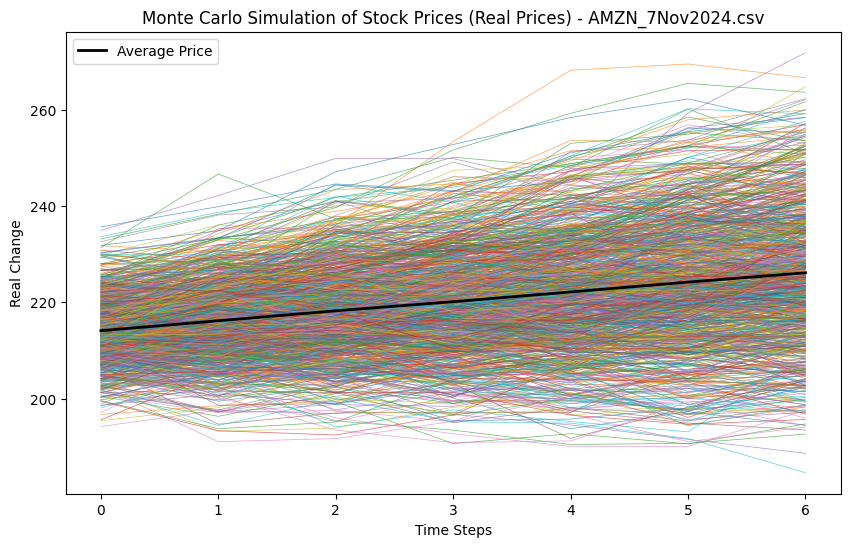

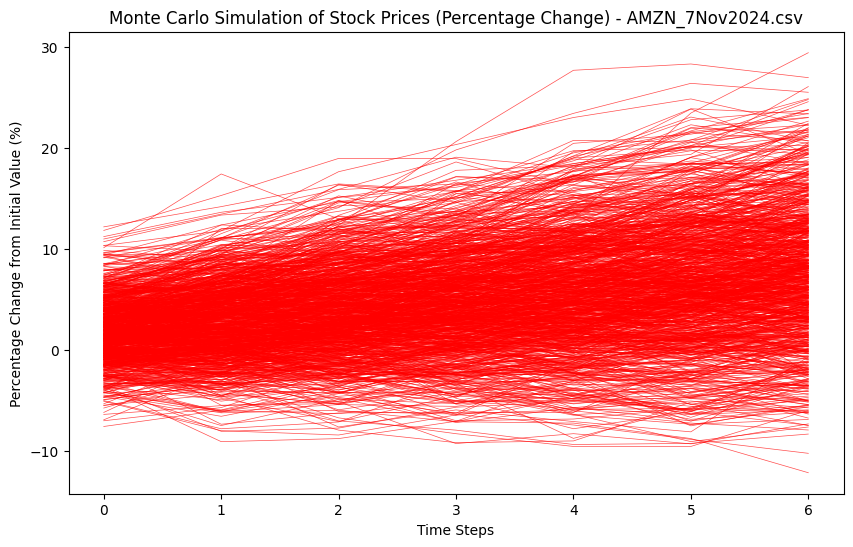

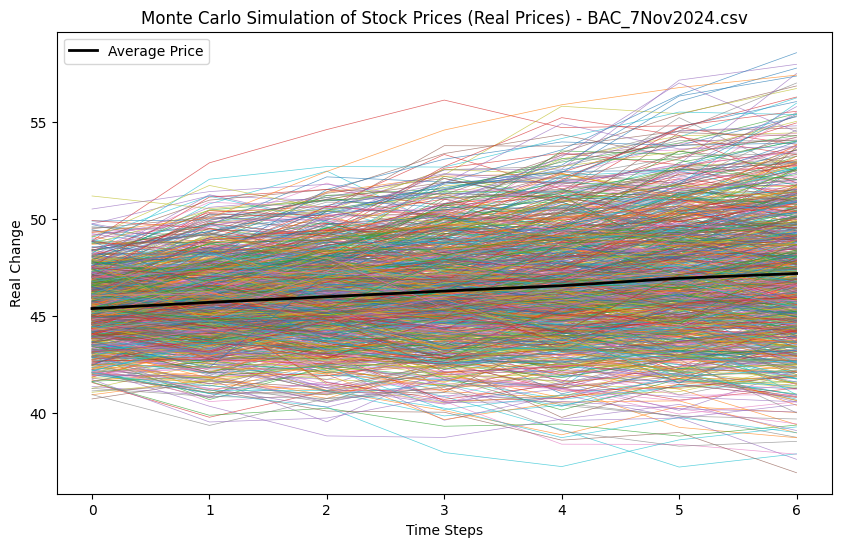

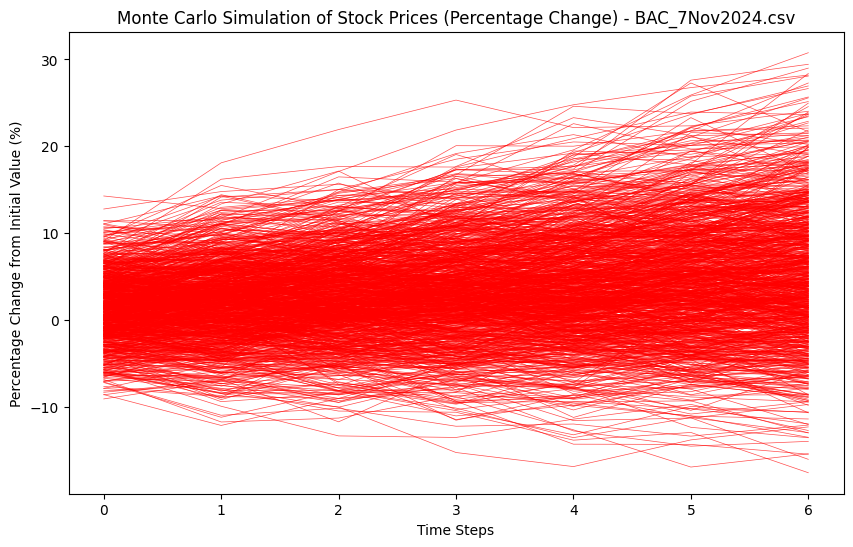

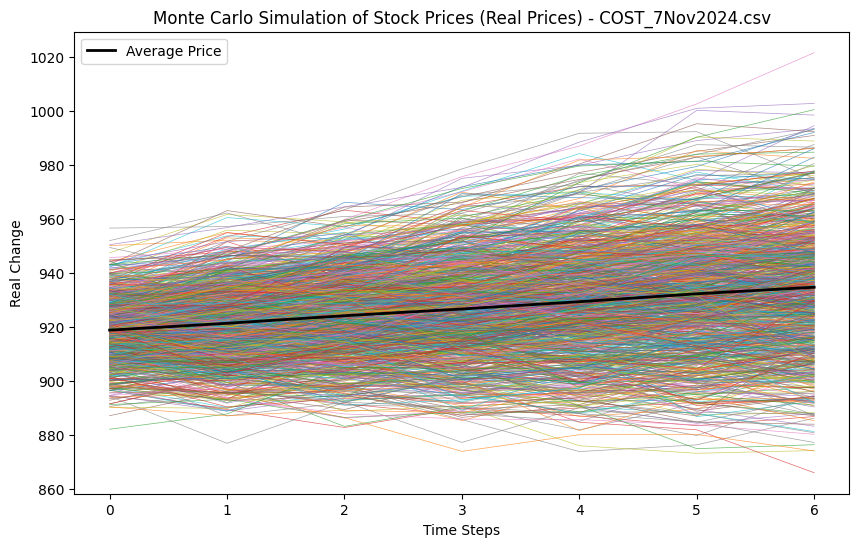

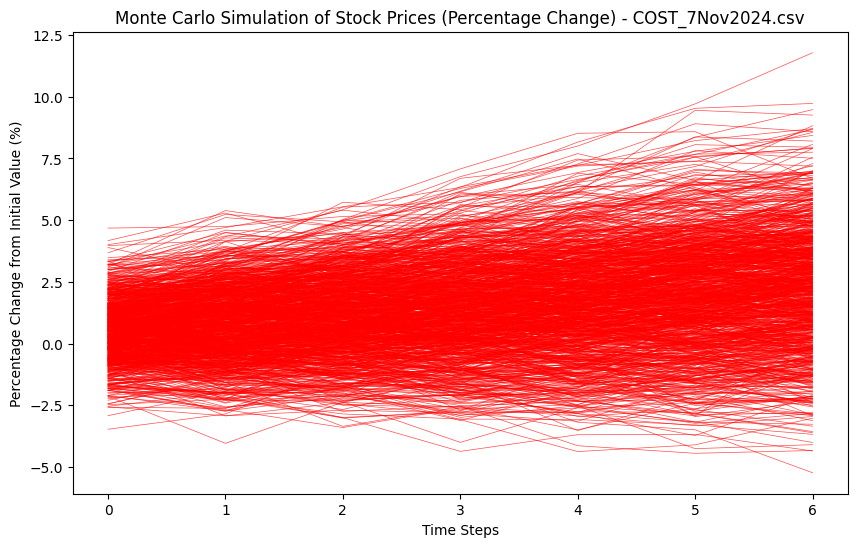

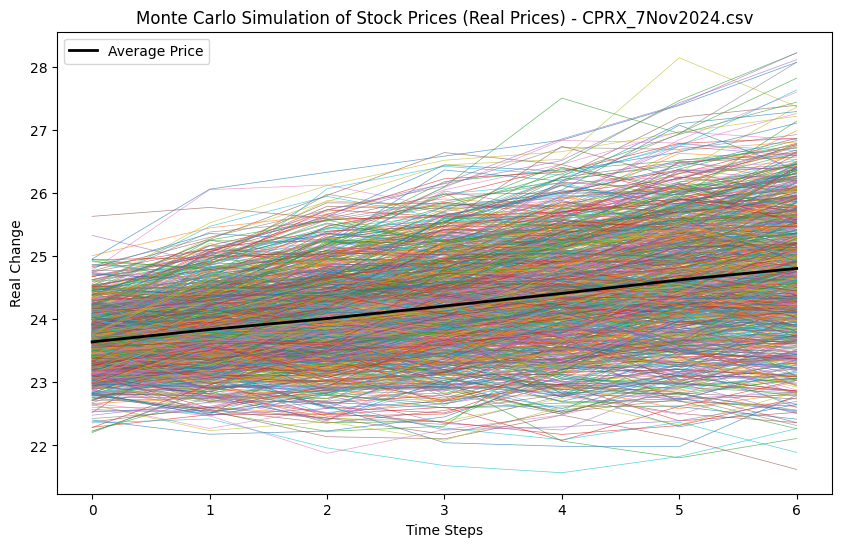

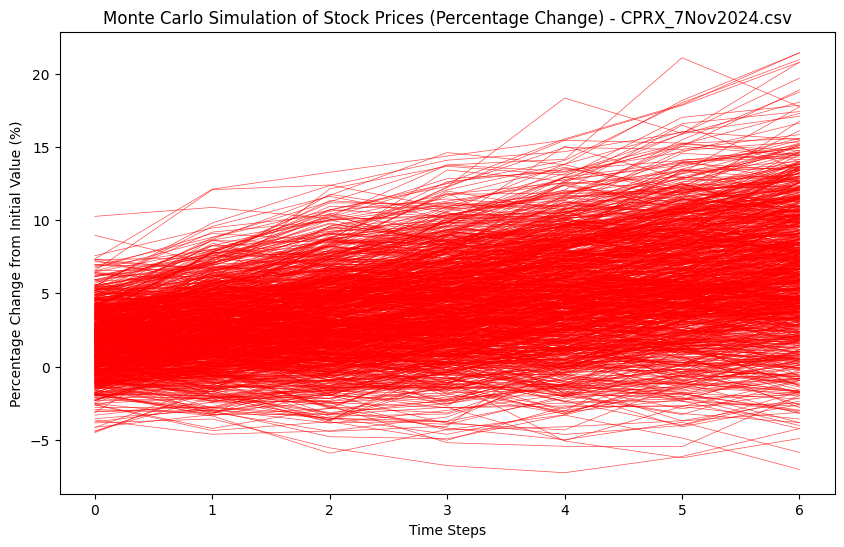

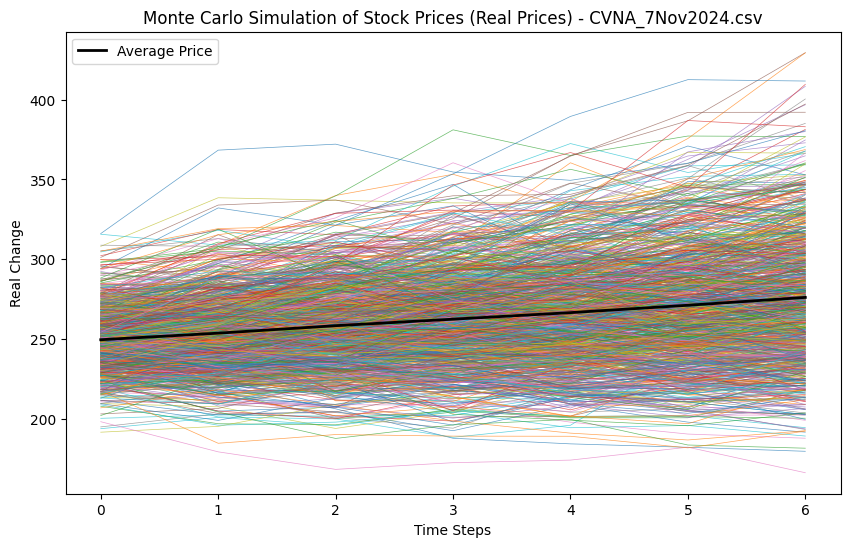

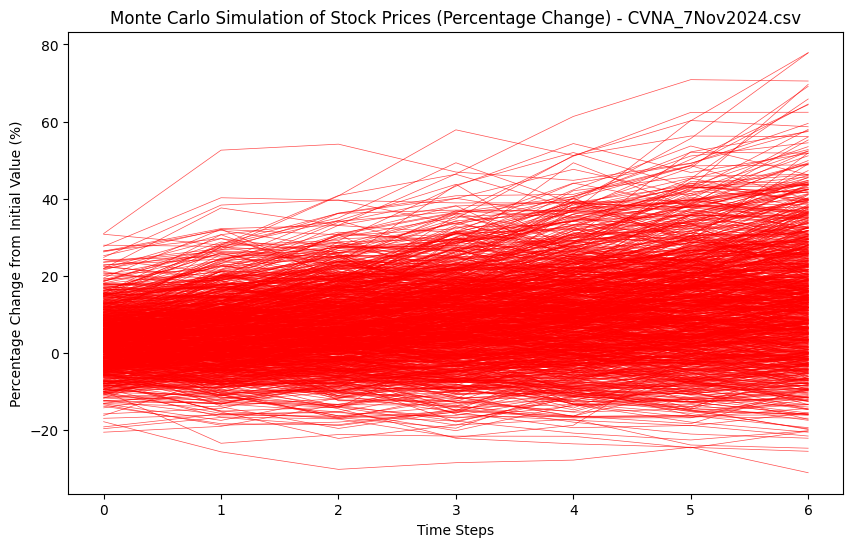

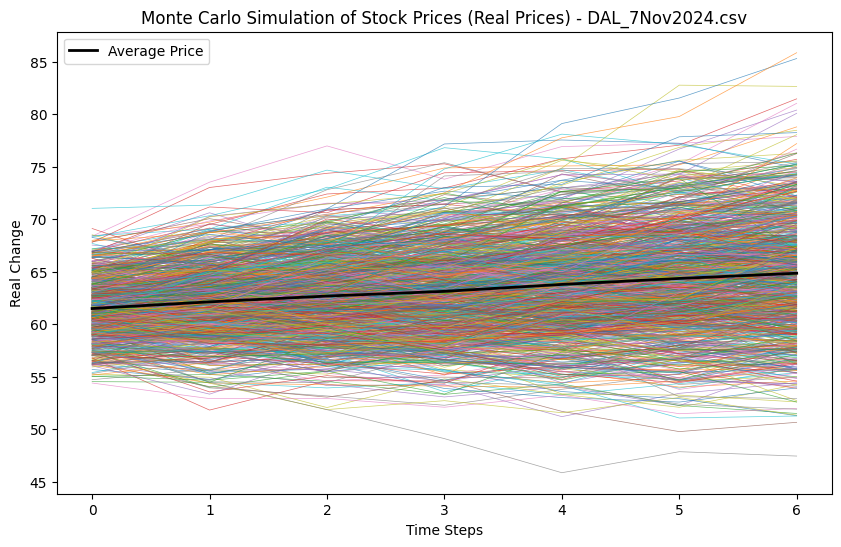

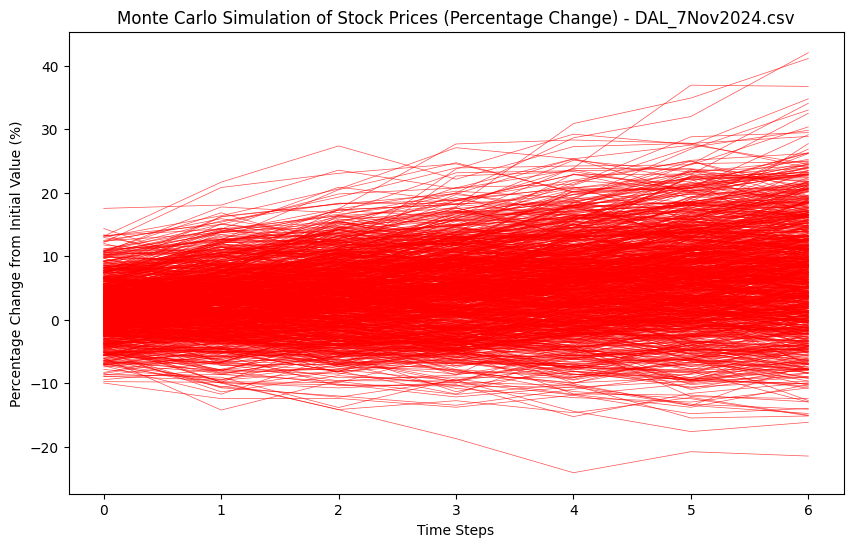

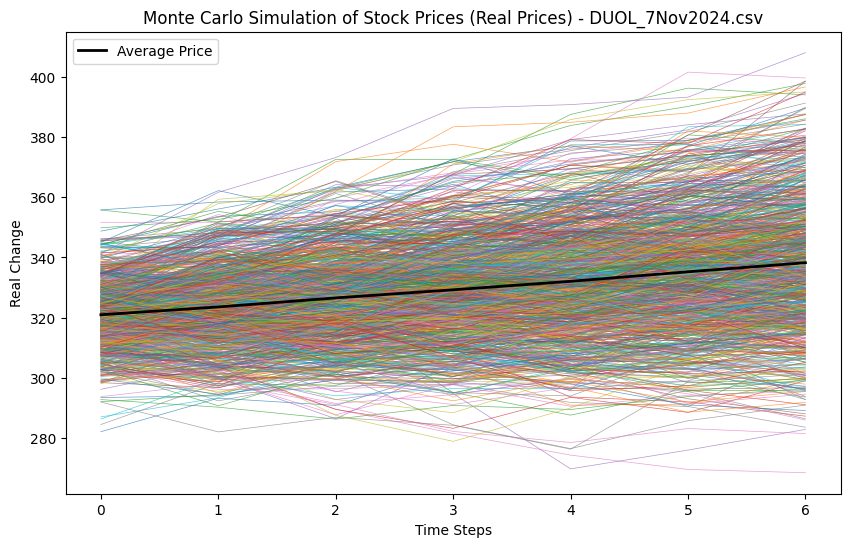

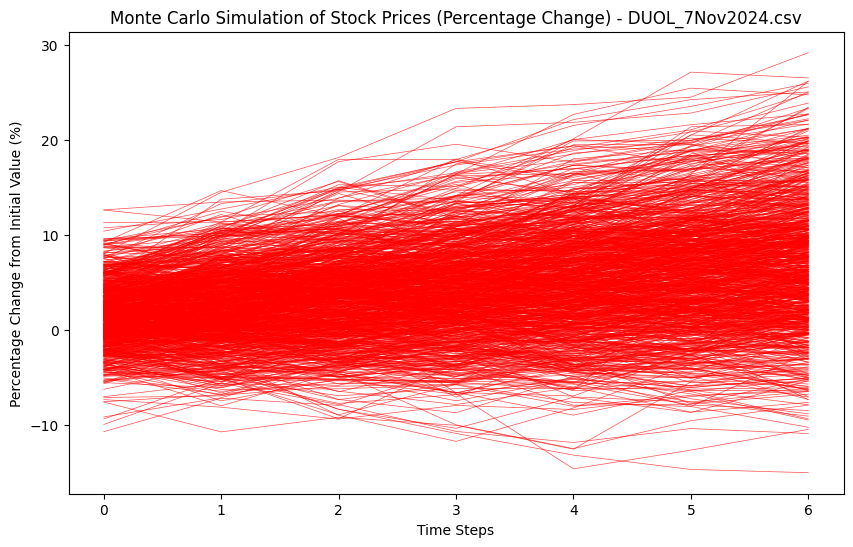

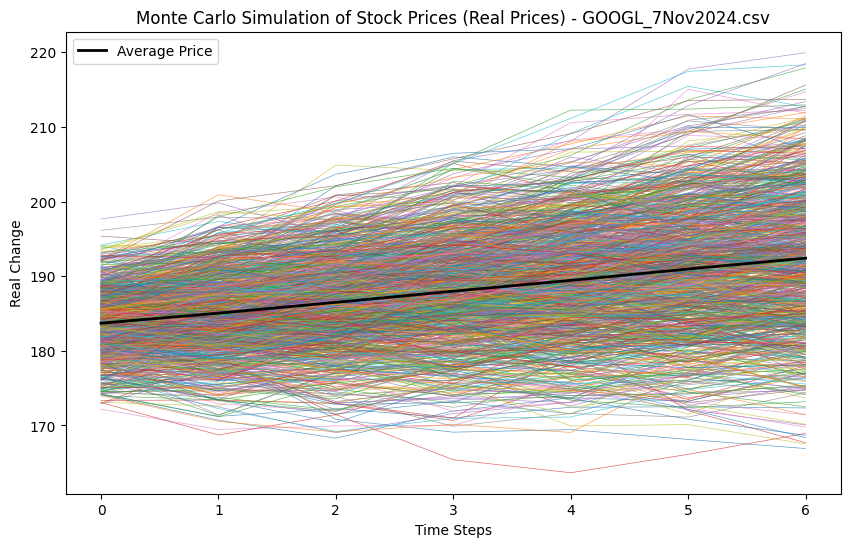

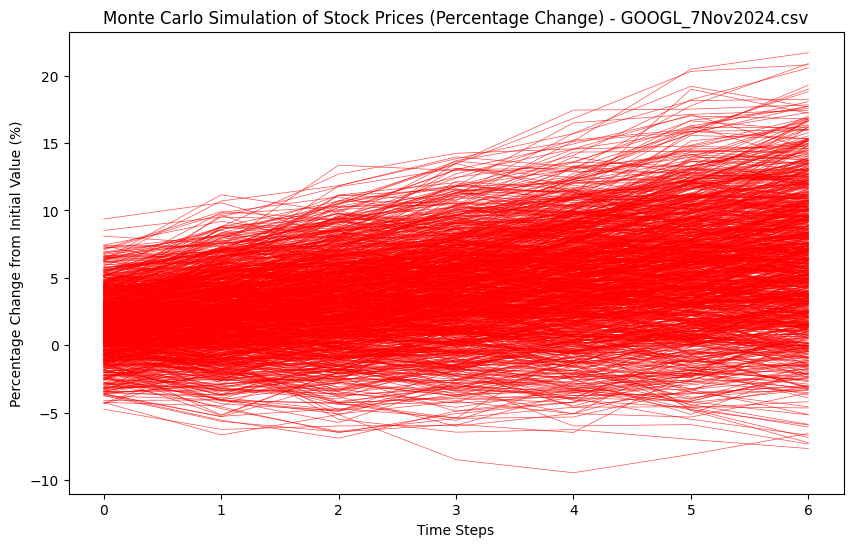

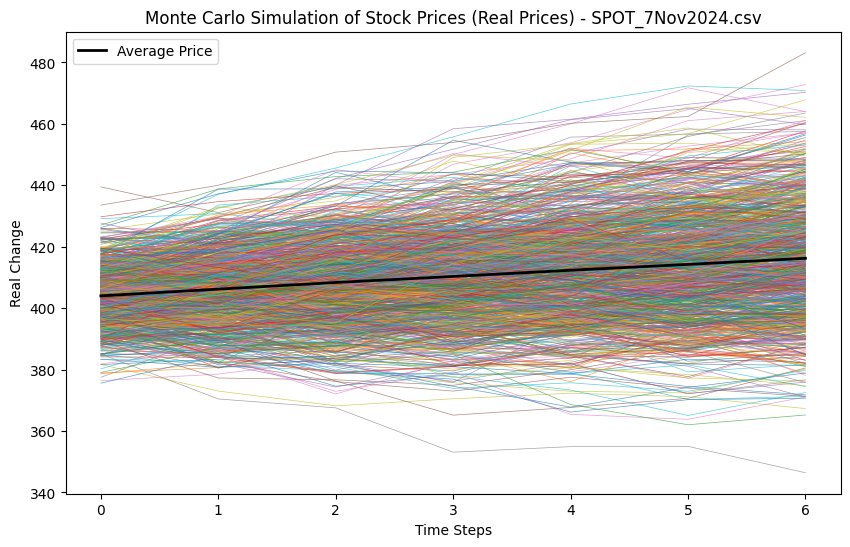

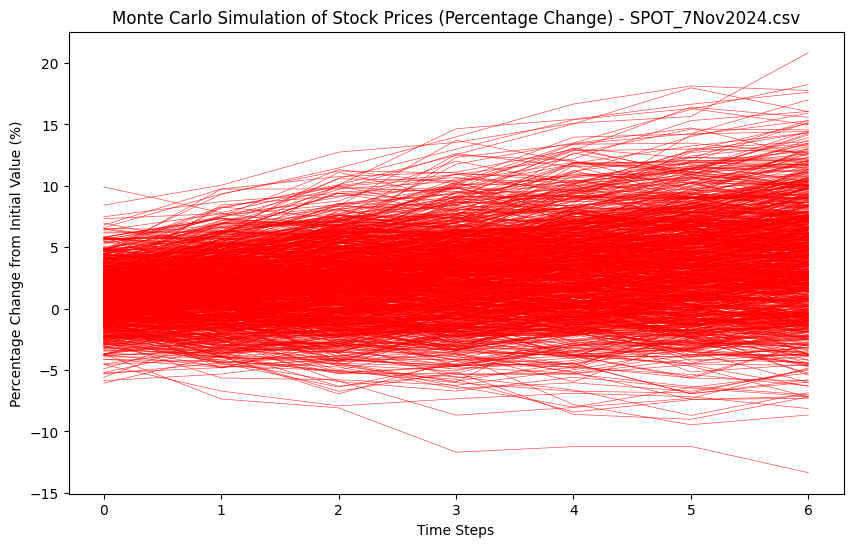

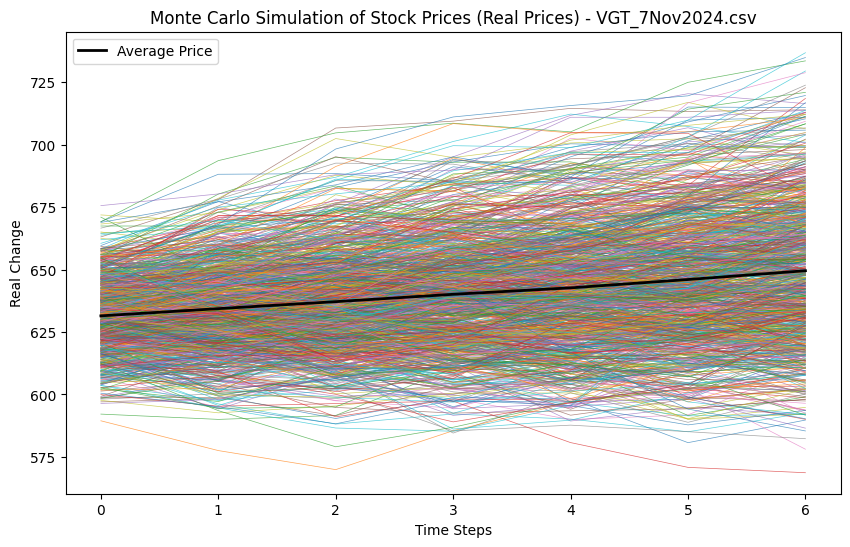

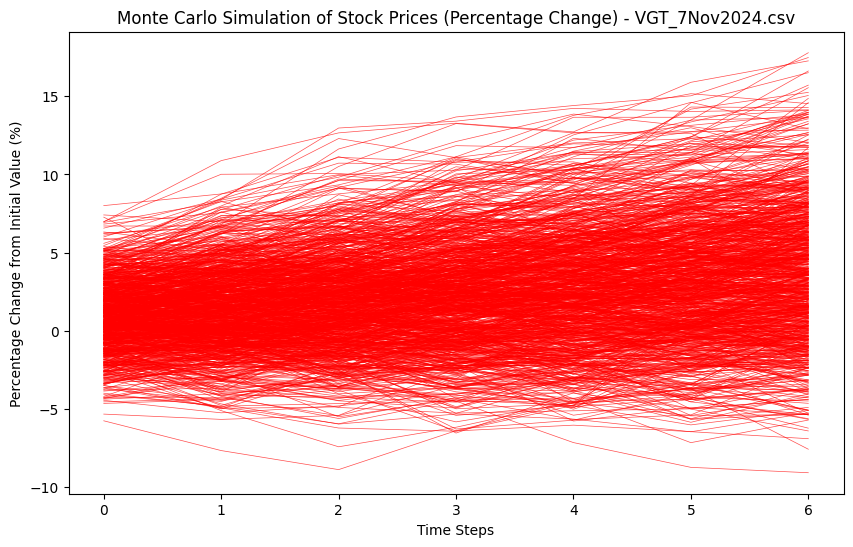

In [4]:
# Store and reuse simulation results
simulation_results = {}
for stock in stocks:
    average_prices, all_real_changes, all_percentage_changes, initial_value = monte_carlo(stock)
    simulation_results[stock] = {
        'average_prices': average_prices,
        'all_real_changes': all_real_changes,
        'all_percentage_changes': all_percentage_changes,
        'initial_value': initial_value
    }

# Plotting using stored results
for stock in stocks:
    data = simulation_results[stock]

    # Figure 1: Real Changes
    plt.figure(figsize=(10, 6))
    for real_changes in data['all_real_changes']:
        plt.plot(real_changes + data['initial_value'], linewidth=0.5, alpha=0.7)

    plt.plot(data['average_prices'], linewidth=2, color='black', label='Average Price')

    plt.title(f'Monte Carlo Simulation of Stock Prices (Real Prices) - {stock}')
    plt.xlabel('Time Steps')
    plt.ylabel('Real Change')
    plt.legend()
    plt.show()

    # Figure 2: Percentage Changes
    plt.figure(figsize=(10, 6))
    for percentage_changes in data['all_percentage_changes']:
        plt.plot(percentage_changes, linewidth=0.5, alpha=0.7, color='red')

    plt.title(f'Monte Carlo Simulation of Stock Prices (Percentage Change) - {stock}')
    plt.xlabel('Time Steps')
    plt.ylabel('Percentage Change from Initial Value (%)')
    plt.show()

# Create simulated_returns DataFrame
simulated_returns = pd.DataFrame({
    stock: simulation_results[stock]['average_prices'] for stock in stocks
})

In [5]:
simulated_returns

AMZN_7Nov2024.csv  BAC_7Nov2024.csv  COST_7Nov2024.csv  CPRX_7Nov2024.csv  \
0         214.101355         45.373771         918.906557          23.642709   
1         216.162762         45.692380         921.442973          23.838505   
2         218.238412         45.980403         924.244698          24.012086   
3         220.123355         46.274959         926.735163          24.211389   
4         222.152939         46.551187         929.436089          24.411746   
5         224.199836         46.932946         932.364369          24.625957   
6         226.134452         47.177565         934.792685          24.808070   

   CVNA_7Nov2024.csv  DAL_7Nov2024.csv  DUOL_7Nov2024.csv  GOOGL_7Nov2024.csv  \
0         249.620437         61.494564         320.969142          183.706356   
1         253.725728         62.128882         323.558033          185.052468   
2         258.422096         62.681897         326.566409          186.501359   
3         262.490992         63.129797         329.258550          188.000620   
4         266.596229         63.788099         332.081484          189.445596   
5         271.207729         64.357762         335.238543          190.969261   
6         276.123858         64.853339         338.246983          192.428132   

   SPOT_7Nov2024.csv  VGT_7Nov2024.csv  
0         404.005884        631.482976  
1         406.188561        634.365527  
2         408.352165        637.167748  
3         410.314110        640.112223  
4         412.342242        642.692764  
5         414.234797        646.024815  
6         416.224301        649.554517

In [6]:
# Calculate Mean Returns and Covariance Matrix
mean_returns = simulated_returns.mean()
cov_matrix = simulated_returns.cov()

# Portfolio Performance Function
def portfolio_performance(weights, mean_returns, cov_matrix):
  stock_weights = weights[:-1] # Weights for stocks
  cash_weight = weights[-1] #Weight for cash

  returns = np.sum(mean_returns * stock_weights) + cash_weight * risk_free_rate
  std = np.sqrt(np.dot(stock_weights.T, np.dot(cov_matrix, stock_weights)))
  return std, returns

# Optimization Functions
def minimize_volatility(weights, mean_returns, cov_matrix):
  return portfolio_performance(weights, mean_returns, cov_matrix)[0]

def maximize_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
  returns = portfolio_performance(weights, mean_returns, cov_matrix)[1]
  std = portfolio_performance(weights, mean_returns, cov_matrix)[0]
  return - (returns - risk_free_rate) / std

# Initial weights (equal distribution among stocks and cash)
initial_weights = (len(mean_returns) + 1) * [1. / (len(mean_returns) + 1)]
risk_free_rate = 0.04

# Constraints and Bounds
# constraints = ({'type': 'ineq', 'fun': lambda x: np.sum(x) - 1})  # Sum of weights less than or equal to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x[:-1]) + x[-1] - 1})
bounds = tuple((0.05, 0.15) for _ in range(len(mean_returns))) + ((0,1),) # Weights between 0.05 and 0.15

# Optimize for Minimum Volatility
# Use initial_weights for the initial guess
result_vol = sco.minimize(minimize_volatility, initial_weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights_vol = result_vol.x

# Optimize for Maximum Sharpe Ratio
# Use initial_weights for the initial guess
result_sharpe = sco.minimize(maximize_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights_sharpe = result_sharpe.x

# # Results
# print(f"Optimal Weights for Minimum Volatility: {opt_weights_vol}")
# print(f"Optimal Weights for Maximum Sharpe Ratio: {opt_weights_sharpe}")

# Results
print("Optimal Weights for Minimum Volatility:")
for i, weight in enumerate(opt_weights_vol[:-1]): # Iterate until the second to last element
    print(f"{stock_name[i]}: {weight:.5f}")  # Format weight to 4 decimal places
print(f"Cash: {opt_weights_vol[-1]:.5f}")  # Print cash weight separately

print("\nOptimal Weights for Maximum Sharpe Ratio:")
for i, weight in enumerate(opt_weights_sharpe[:-1]): # Iterate until the second to last element
    print(f"{stock_name[i]}: {weight:.5f}")  # Format weight to 4 decimal places
print(f"Cash: {opt_weights_sharpe[-1]:.5f}")  # Print cash weight separately

Optimal Weights for Minimum Volatility:
AMZN: 0.05000
BAC: 0.05000
COST: 0.05000
CPRX: 0.05000
CVNA: 0.05000
DAL: 0.05000
DUOL: 0.05000
GOOGL: 0.05000
SPOT: 0.05000
VGT: 0.05000
Cash: 0.50000

Optimal Weights for Maximum Sharpe Ratio:
AMZN: 0.05000
BAC: 0.05000
COST: 0.15000
CPRX: 0.05000
CVNA: 0.05000
DAL: 0.05000
DUOL: 0.05000
GOOGL: 0.05000
SPOT: 0.05000
VGT: 0.15000
Cash: 0.30000
